In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
from statsmodels.stats.weightstats import DescrStatsW, CompareMeans

# Importando bibliotecas:

# A Tabela

## A tabela users (dados sobre usuários):
* user_id    — identificação do usuário;
* first_name — nome do usuário
* last_name  — último sobrenome do usuário
* age        — idade do usuário (em anos)
* reg_date   — data da inscrição (dd, mm, aa)
* churn_date — a data que o usuário parou de usar o serviço (se o valor for ausente, o plano estava sendo usado quando esse dado foi gerado)
* city       — cidade de residência do usuário
* plan       — nome do plano


## A tabela calls (dados sobre as chamadas)
* id        — identificador de chamada unívoco
* call_date — data da chamada
* duration  — duração da chamada (em minutos)
* user_id   — o identificador do usuário que faz a chamada


## A tabela messages (dados nas mensagens de texto):
* id            — identificador unívoco de mensagem de textos
* message_date  — data da mensagem de texto
* user_id       — o identificador do usuário que envia a mensagem de texto


## A tabela internet (dados sobre sessões web):
* id            — identificador de sessão unívoco
* mb_used       — o volume de dados gasto durante a sessão ( em megabytes)
* session_date  — data da sessão web
* user_id       — identificador do usuário


## A tabela plans(dados sobre os planos):
* plan_name             — o nome do plano de chamadas
* usd_monthly_fee       — preço mensal em dólares dos EUA
* minutes_included      — pacote de minutos mensal
* messages_included     — pacote de mensagens de texto mensal
* mb_per_month_included — pacote de volume de dados (em megabytes)
* usd_per_minute        — preço por minuto depois de exceder o limite do pacote (por exemplo, se o pacote inclui 100 minutos, o primeiro minuto excedente será cobrado)
* usd_per_message       — preço por mensagem de texto depois de exceder o limite do pacote
* usd_per_gb            — preço por gigabyte extra de dados após exceder o limite do pacote (1 GB = 1024 megabytes)

# Descrição dos planos

A cliente arredonda segundos para minutos, e megabytes para gigabytes. Para chamadas, cada chamada individual é arredondada para cima: mesmo se uma chamada tenha durado apenas um segundo, será contado como um minuto. Para trafego de web, sessões individuais de web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. Se alguém usar 1025 megabytes esse mês, eles serão cobrados por 2 gigabytes.

## Surf
* Preço mensal: $20
* 500 minutos mensais, 50 mensagens de texto, e 15 GB de dados
* Depois de exceder os limites do pacote:
* 1 minuto: 3 centavos
* 1 mensagem de texto: 3 centavos
* 1 GB de dados: $10

## Ultimate
* Preço mensal: $70
* 3000 minutos mensais, 1000 mensagens de texto, e 30 GB de dados
* Depois de exceder os limites do pacote:
* 1 minuto: 1 centavo
* 1 mensagem de texto: 1 centavo
* 1 GB de dados: $7

# Carregando o arquivo com os dados em DataFrames

In [2]:


try:     
    df_users = pd.read_csv(r'megaline_users.csv') 
    df_calls = pd.read_csv(r'megaline_calls.csv') 
    df_internet = pd.read_csv(r'megaline_internet.csv') 
    df_plans = pd.read_csv(r'megaline_plans.csv') 
    df_messages = pd.read_csv(r'megaline_messages.csv') 
except:
    df_users = pd.read_csv(r'/datasets/megaline_users.csv') 
    df_calls = pd.read_csv(r'/datasets/megaline_calls.csv') 
    df_internet = pd.read_csv(r'/datasets/megaline_internet.csv') 
    df_plans = pd.read_csv(r'/datasets/megaline_plans.csv') 
    df_messages = pd.read_csv(r'/datasets/megaline_messages.csv') 

In [3]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [4]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
df_users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [6]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
df_calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [8]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [10]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [11]:
df_internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [12]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


# Tratamento de dados

Os dados serão tratados de acordo com a recomendação da cliente, que é: 
> * arredondar segundos para minutos e megabytes para gigabytes;
> * Para chamadas, cada chamada individual é arredondada para cima, mesmo que a chamada tenha durado apenas um segundo será contado como um minuto;
> * Para trafego de web, sessões individuais de web não são arredondadas para cima. Ao invés disso, o total do mês é arredondado para cima. **Se alguém usar 1025 megabytes esse mês, eles serão cobrados por 2 gigabytes**.

Posto isso, tais alterações serão feitas nos dados que carecem de arredondamento e eventuais criações de novas colunas podem ocorrer caso seja necessário a contabilização de algum valor final.

## Tratamento de incongruências no tipo de dados e condicionamento dos dados ao exposto pelo cliente

> ## Users

In [13]:
df_users

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


In [14]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
# df_users

df_users['reg_date'] = pd.to_datetime(df_users.reg_date)
df_users['reg_date'] = df_users['reg_date'].dt.strftime('%d-%m-%Y')
df_users['churn_date'] = pd.to_datetime(df_users.churn_date)
df_users['churn_date'] = df_users['churn_date'].dt.strftime('%d-%m-%Y')
df_users['reg_date'] = pd.to_datetime(df_users.reg_date, format='%d-%m-%Y')
df_users['reg_month'] = df_users['reg_date'].dt.strftime('%m').astype(int)


In [16]:
df_users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,5


In [17]:
df_users.duplicated().sum()

0

In [18]:
df_users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
reg_month       0
dtype: int64

In [19]:
df_users.city.unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

>## Calls

In [20]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [21]:
df_calls.duplicated().sum()

0

In [22]:
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls['call_date'] = pd.to_datetime(df_calls.call_date)
df_calls['call_date'] = df_calls['call_date'].dt.strftime('%d-%m-%Y')
df_calls['call_date'] = pd.to_datetime(df_calls.call_date, format='%d-%m-%Y')
df_calls['month'] = df_calls['call_date'].dt.strftime('%m').astype(int)
df_calls['call_date'] = df_calls['call_date'].dt.strftime('%d-%m-%Y')
df_calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,27-12-2018,9.0,12
1,1000_145,1000,27-12-2018,14.0,12
2,1000_247,1000,27-12-2018,15.0,12
3,1000_309,1000,28-12-2018,6.0,12
4,1000_380,1000,30-12-2018,5.0,12


> ## Messages

In [23]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
df_messages.duplicated().sum()

0

In [25]:
df_messages['message_date'] = pd.to_datetime(df_messages.message_date)
df_messages['message_date'] = df_messages['message_date'].dt.strftime('%d-%m-%Y')
df_messages['message_date'] = pd.to_datetime(df_messages.message_date, format='%d-%m-%Y')
df_messages['month'] = df_messages['message_date'].dt.strftime('%m').astype(int)
df_messages['message_date'] = df_messages['message_date'].dt.strftime('%d-%m-%Y')
df_messages.head()

,id,user_id,message_date,month
0,1000_125,1000,27-12-2018,12
1,1000_160,1000,31-12-2018,12
2,1000_223,1000,31-12-2018,12
3,1000_251,1000,27-12-2018,12
4,1000_255,1000,26-12-2018,12


> ### Internet

In [26]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [27]:
df_internet.duplicated().sum()

0

In [28]:
df_internet['session_date'] = pd.to_datetime(df_internet.session_date)
df_internet['session_date'] = df_internet['session_date'].dt.strftime('%d-%m-%Y')
df_internet['session_date'] = pd.to_datetime(df_internet.session_date, format='%d-%m-%Y')
df_internet['month'] = df_internet['session_date'].dt.strftime('%m').astype(int)
df_internet['session_date'] = df_internet['session_date'].dt.strftime('%d-%m-%Y')
df_internet['gb_used'] = df_internet['mb_used'] / 1024
df_internet.head()

,id,user_id,session_date,mb_used,month,gb_used
0,1000_13,1000,29-12-2018,89.86,12,0.087754
1,1000_204,1000,31-12-2018,0.00,12,0.000000
2,1000_379,1000,28-12-2018,660.40,12,0.644922
3,1000_413,1000,26-12-2018,270.99,12,0.264639
4,1000_442,1000,27-12-2018,880.22,12,0.859590


> ### Plans

In [29]:
df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [30]:
df_plans.duplicated().sum()

0

In [31]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


### Conclusão sobre erros

Os Data Frames encontram-se com poucos erros, sem duplicatas, os valores ausentes existem não por erro mas por serem necessários, pois os valores ausentes na coluna *'churn_date'* do Data Set *Users*, são referentes a estado do contrato, logo os valroes ausentes significam que os contratos ainda estão ativos. 

# Criando novos DataFrames

In [32]:
df_call_user = df_users.merge(df_calls)
df_call_user.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,id,call_date,duration,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_93,27-12-2018,9.0,12
1,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_145,27-12-2018,14.0,12
2,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_247,27-12-2018,15.0,12
3,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_309,28-12-2018,6.0,12
4,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_380,30-12-2018,5.0,12


In [33]:
df_net_user = df_users.merge(df_internet)
df_net_user.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,id,session_date,mb_used,month,gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_13,29-12-2018,89.86,12,0.087754
1,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_204,31-12-2018,0.00,12,0.000000
2,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_379,28-12-2018,660.40,12,0.644922
3,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_413,26-12-2018,270.99,12,0.264639
4,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_442,27-12-2018,880.22,12,0.859590


In [34]:
df_msg_user = df_users.merge(df_messages)
df_msg_user.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,id,message_date,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_125,27-12-2018,12
1,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_160,31-12-2018,12
2,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_223,31-12-2018,12
3,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_251,27-12-2018,12
4,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_255,26-12-2018,12


## Tratamento dos Dados

>## Calls

In [35]:
df_call_user[df_call_user['duration'] == 0]

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,id,call_date,duration,month
19,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,1001_4,05-12-2018,0.0,12
25,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,1001_13,24-12-2018,0.0,12
31,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,1001_30,17-10-2018,0.0,10
32,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,1001_31,03-11-2018,0.0,11
34,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,1001_35,21-12-2018,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137714,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_183,10-11-2018,0.0,11
137715,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_184,15-09-2018,0.0,9
137720,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_189,27-12-2018,0.0,12
137722,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_191,24-12-2018,0.0,12


In [36]:
round((df_call_user[df_call_user['duration'] == 0].shape[0] / df_call_user.shape[0]) * 100, 2)

19.48

In [37]:
df_call_user.query('duration > 0').duration.describe()

count    110901.000000
mean          8.875907
std           5.355181
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64

In [38]:
pivot_calls = df_call_user.pivot_table(index = ['plan','user_id', 'month'], values = 'duration', aggfunc = ['sum', 'count'])
pivot_calls = pivot_calls.reset_index()
pivot_calls.columns = ['plan', 'user_id', 'month', 'monthly_duration', 'outgoing_calls']
pivot_calls

,plan,user_id,month,monthly_duration,outgoing_calls
0,surf,1001,8,182.0,27
1,surf,1001,9,315.0,49
2,surf,1001,10,393.0,65
3,surf,1001,11,426.0,64
4,surf,1001,12,412.0,56
...,...,...,...,...,...
2253,ultimate,1493,9,529.0,66
2254,ultimate,1493,10,450.0,66
2255,ultimate,1493,11,500.0,73
2256,ultimate,1493,12,473.0,65


>## Messages

In [39]:
df_msg_user.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,id,message_date,month
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_125,27-12-2018,12
1,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_160,31-12-2018,12
2,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_223,31-12-2018,12
3,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_251,27-12-2018,12
4,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_255,26-12-2018,12


In [40]:
pivot_messages = df_msg_user.pivot_table(index = ['plan','user_id', 'month'], values = 'message_date', aggfunc = 'count')
pivot_messages = pivot_messages.reset_index()
pivot_messages.columns = ['plan', 'user_id', 'month', 'messages_sent']
pivot_messages

,plan,user_id,month,messages_sent
0,surf,1001,8,30
1,surf,1001,9,44
2,surf,1001,10,53
3,surf,1001,11,36
4,surf,1001,12,44
...,...,...,...,...
1801,ultimate,1482,10,2
1802,ultimate,1482,11,87
1803,ultimate,1482,12,5
1804,ultimate,1487,12,66


>## Internet

In [41]:
df_net_user

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,id,session_date,mb_used,month,gb_used
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_13,29-12-2018,89.86,12,0.087754
1,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_204,31-12-2018,0.00,12,0.000000
2,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_379,28-12-2018,660.40,12,0.644922
3,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_413,26-12-2018,270.99,12,0.264639
4,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12,1000_442,27-12-2018,880.22,12,0.859590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104820,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_215,20-10-2018,218.06,10,0.212949
104821,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_216,30-12-2018,304.72,12,0.297578
104822,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_217,22-09-2018,292.75,9,0.285889
104823,1499,Shena,Dickson,37,"Orlando-Kissimmee-Sanford, FL MSA",2018-05-06,surf,NaN,5,1499_218,07-12-2018,0.00,12,0.000000


In [42]:
df_net_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       104825 non-null  int64         
 1   first_name    104825 non-null  object        
 2   last_name     104825 non-null  object        
 3   age           104825 non-null  int64         
 4   city          104825 non-null  object        
 5   reg_date      104825 non-null  datetime64[ns]
 6   plan          104825 non-null  object        
 7   churn_date    7466 non-null    object        
 8   reg_month     104825 non-null  int32         
 9   id            104825 non-null  object        
 10  session_date  104825 non-null  object        
 11  mb_used       104825 non-null  float64       
 12  month         104825 non-null  int32         
 13  gb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2), object(7)
memo

In [43]:
pivot_internet = df_net_user.pivot_table(index = ['plan','user_id', 'month'], values = ['mb_used'], aggfunc = ['sum'])
pivot_internet = pivot_internet.reset_index()
pivot_internet.columns = ['plan', 'user_id', 'month', 'mb_used']
pivot_internet['gb_used'] = np.ceil(pivot_internet['mb_used']/1024)
pivot_internet

,plan,user_id,month,mb_used,gb_used
0,surf,1001,8,6919.15,7.0
1,surf,1001,9,13314.82,14.0
2,surf,1001,10,22330.49,22.0
3,surf,1001,11,18504.30,19.0
4,surf,1001,12,19369.18,19.0
...,...,...,...,...,...
2272,ultimate,1493,9,14991.17,15.0
2273,ultimate,1493,10,16329.57,16.0
2274,ultimate,1493,11,15630.78,16.0
2275,ultimate,1493,12,15289.09,15.0


### Data Frame final para análise

In [44]:
consum_total = pd.merge(pivot_calls, pivot_internet, how='outer')
consum_total

,plan,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used
0,surf,1001,8,182.0,27.0,6919.15,7.0
1,surf,1001,9,315.0,49.0,13314.82,14.0
2,surf,1001,10,393.0,65.0,22330.49,22.0
3,surf,1001,11,426.0,64.0,18504.30,19.0
4,surf,1001,12,412.0,56.0,19369.18,19.0
...,...,...,...,...,...,...,...
2287,ultimate,1108,12,NaN,NaN,233.17,1.0
2288,ultimate,1204,11,NaN,NaN,21346.95,21.0
2289,ultimate,1204,12,NaN,NaN,36730.05,36.0
2290,ultimate,1224,6,NaN,NaN,2966.21,3.0


In [45]:
consum_total = consum_total.merge(pivot_messages, how='outer')
consum_total

,plan,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used,messages_sent
0,surf,1001,8,182.0,27.0,6919.15,7.0,30.0
1,surf,1001,9,315.0,49.0,13314.82,14.0,44.0
2,surf,1001,10,393.0,65.0,22330.49,22.0,53.0
3,surf,1001,11,426.0,64.0,18504.30,19.0,36.0
4,surf,1001,12,412.0,56.0,19369.18,19.0,44.0
...,...,...,...,...,...,...,...,...
2288,ultimate,1204,11,NaN,NaN,21346.95,21.0,42.0
2289,ultimate,1204,12,NaN,NaN,36730.05,36.0,78.0
2290,ultimate,1224,6,NaN,NaN,2966.21,3.0,5.0
2291,ultimate,1311,6,NaN,NaN,1498.83,2.0,NaN


In [46]:
# Preenchendo valores ausentes
consum_total['monthly_duration'].fillna(0, inplace=True)
consum_total['outgoing_calls'].fillna(0, inplace=True)
consum_total['mb_used'].fillna(0, inplace=True)
consum_total['gb_used'].fillna(0, inplace=True)
consum_total['messages_sent'].fillna(0, inplace=True)
consum_total.isna().sum()

plan                0
user_id             0
month               0
monthly_duration    0
outgoing_calls      0
mb_used             0
gb_used             0
messages_sent       0
dtype: int64

In [47]:
consum_total

,plan,user_id,month,monthly_duration,outgoing_calls,mb_used,gb_used,messages_sent
0,surf,1001,8,182.0,27.0,6919.15,7.0,30.0
1,surf,1001,9,315.0,49.0,13314.82,14.0,44.0
2,surf,1001,10,393.0,65.0,22330.49,22.0,53.0
3,surf,1001,11,426.0,64.0,18504.30,19.0,36.0
4,surf,1001,12,412.0,56.0,19369.18,19.0,44.0
...,...,...,...,...,...,...,...,...
2288,ultimate,1204,11,0.0,0.0,21346.95,21.0,42.0
2289,ultimate,1204,12,0.0,0.0,36730.05,36.0,78.0
2290,ultimate,1224,6,0.0,0.0,2966.21,3.0,5.0
2291,ultimate,1311,6,0.0,0.0,1498.83,2.0,0.0


In [48]:
df_user_consum = pd.merge(df_users, consum_total, how='right')
df_user_consum

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,month,monthly_duration,outgoing_calls,mb_used,gb_used,messages_sent
0,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,8,182.0,27.0,6919.15,7.0,30.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,9,315.0,49.0,13314.82,14.0,44.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,10,393.0,65.0,22330.49,22.0,53.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,11,426.0,64.0,18504.30,19.0,36.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,12,412.0,56.0,19369.18,19.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN,8,11,0.0,0.0,21346.95,21.0,42.0
2289,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN,8,12,0.0,0.0,36730.05,36.0,78.0
2290,1224,Kelly,Cole,74,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-06-28,ultimate,NaN,6,6,0.0,0.0,2966.21,3.0,5.0
2291,1311,Cherlyn,Saunders,69,"Memphis, TN-MS-AR MSA",2018-06-27,ultimate,NaN,6,6,0.0,0.0,1498.83,2.0,0.0


># Conclusão Intermediária do Tratamento

* No decorrer da criação do novo Data Frame, nos deparamos com valores ausentes em algumas colunas que antes não existiam, mas era esperado dada a fusão dos Data Frames. Pois é natural a eventual não utilização de algum serviço do pacote contratado em algum momento. Logo, a ausência de dados significa também a não utilização, por isso tais valores serão preenchidos com o número 0. 

* Diferente do DataFrame de chamadas (Calls), que o numero 0 significa possivelmente um tentativa falha de contato, que não será alterado para fim de contabilidade de chamadas, podendo ser separado havendo necessidade para uma eventual análise do tempo das chamadas, pois devemos calcular as chamadas efetuadas com sucesso.

### Criando funções para o Data Frame finalizado

In [49]:
def calls(row):
    plan = row['plan']
    duration = row['monthly_duration']
    surp = 0

    if plan == 'surf':
        if duration > 500:
            surp += duration - 500
        else:
            surp
    elif plan == 'ultimate':
         if duration > 3000:
            surp += duration - 3000
         else:
            surp
    
    return surp

In [50]:
def message(row):
    plan = row['plan']
    message = row['messages_sent']
    surp = 0

    if plan == 'surf':
        if message > 50:
            surp += message - 50
        else:
            surp
    elif plan == 'ultimate':
         if message > 1000:
            surp += message - 1000
         else:
            surp
    
    return surp

In [51]:
def net(row):
    import numpy as np
    plan = row['plan']
    internet = row['gb_used']
    surf = (np.ceil(15360/1024))
    ult = (np.ceil(30720/1024))

    surp = 0

    if plan == 'surf':
        if internet > surf:
            surp += internet - surf
        else:
            surp
    elif plan == 'ultimate':
         if internet > ult:
            surp += internet - ult
         else:
            surp
    
    return surp

In [52]:
df_plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [53]:
df_user_consum['surplus_calls'] = df_user_consum.apply(calls, axis=1)
df_user_consum['surplus_messages'] = df_user_consum.apply(message, axis=1)
df_user_consum['surplus_gb'] = df_user_consum.apply(net, axis=1)

In [54]:
df_user_consum

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,month,monthly_duration,outgoing_calls,mb_used,gb_used,messages_sent,surplus_calls,surplus_messages,surplus_gb
0,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,8,182.0,27.0,6919.15,7.0,30.0,0.0,0.0,0.0
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,9,315.0,49.0,13314.82,14.0,44.0,0.0,0.0,0.0
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,10,393.0,65.0,22330.49,22.0,53.0,0.0,3.0,7.0
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,11,426.0,64.0,18504.30,19.0,36.0,0.0,0.0,4.0
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,12,412.0,56.0,19369.18,19.0,44.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN,8,11,0.0,0.0,21346.95,21.0,42.0,0.0,0.0,0.0
2289,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN,8,12,0.0,0.0,36730.05,36.0,78.0,0.0,0.0,6.0
2290,1224,Kelly,Cole,74,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-06-28,ultimate,NaN,6,6,0.0,0.0,2966.21,3.0,5.0,0.0,0.0,0.0
2291,1311,Cherlyn,Saunders,69,"Memphis, TN-MS-AR MSA",2018-06-27,ultimate,NaN,6,6,0.0,0.0,1498.83,2.0,0.0,0.0,0.0,0.0


In [55]:
def calc_usd(row):
    plan = row['plan']
    usd_plan= 0
    
    if plan == 'surf':
        usd = 20
        usd_plan += (usd + (row['surplus_calls'] * .03) + (row['surplus_messages'] * .03) + (row['surplus_gb'] * 10))
    
    elif plan == 'ultimate':
        usd = 70 
        usd_plan += (usd + (row['surplus_calls'] * .01) + (row['surplus_messages'] * .01) + (row['surplus_gb'] * 7))
    
    return usd_plan
        



In [56]:
df_user_consum['to_pay'] = df_user_consum.apply(calc_usd, axis=1)
df_user_consum

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,month,monthly_duration,outgoing_calls,mb_used,gb_used,messages_sent,surplus_calls,surplus_messages,surplus_gb,to_pay
0,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,8,182.0,27.0,6919.15,7.0,30.0,0.0,0.0,0.0,20.00
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,9,315.0,49.0,13314.82,14.0,44.0,0.0,0.0,0.0,20.00
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,10,393.0,65.0,22330.49,22.0,53.0,0.0,3.0,7.0,90.09
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,11,426.0,64.0,18504.30,19.0,36.0,0.0,0.0,4.0,60.00
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,12,412.0,56.0,19369.18,19.0,44.0,0.0,0.0,4.0,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN,8,11,0.0,0.0,21346.95,21.0,42.0,0.0,0.0,0.0,70.00
2289,1204,Sherly,Levy,44,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-08-20,ultimate,NaN,8,12,0.0,0.0,36730.05,36.0,78.0,0.0,0.0,6.0,112.00
2290,1224,Kelly,Cole,74,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-06-28,ultimate,NaN,6,6,0.0,0.0,2966.21,3.0,5.0,0.0,0.0,0.0,70.00
2291,1311,Cherlyn,Saunders,69,"Memphis, TN-MS-AR MSA",2018-06-27,ultimate,NaN,6,6,0.0,0.0,1498.83,2.0,0.0,0.0,0.0,0.0,70.00


## Conclusão do tópico de tratamento.

No presente tópico se deu a criação de um DataFrame a ser utilizado para uma análise mais precisa dos dados. 

Para cada usuário, foi encontrado:

* O número de chamadas feitas e minutos usados por mês;
* O número de mensagens de texto enviadas por mês;
* O volume de dados por mês;
* A receita mensal para cada usuário a depender do plano contratado.

# Analise dos dados

## Visualização dos dados

In [57]:
df_user_consum.head(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,reg_month,month,monthly_duration,outgoing_calls,mb_used,gb_used,messages_sent,surplus_calls,surplus_messages,surplus_gb,to_pay
0,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,8,182.0,27.0,6919.15,7.0,30.0,0.0,0.0,0.0,20.00
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,9,315.0,49.0,13314.82,14.0,44.0,0.0,0.0,0.0,20.00
2,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,10,393.0,65.0,22330.49,22.0,53.0,0.0,3.0,7.0,90.09
3,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,11,426.0,64.0,18504.30,19.0,36.0,0.0,0.0,4.0,60.00
4,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8,12,412.0,56.0,19369.18,19.0,44.0,0.0,0.0,4.0,60.00
5,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,10,10,59.0,11.0,6552.01,7.0,15.0,0.0,0.0,0.0,20.00
6,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,10,11,386.0,55.0,19345.08,19.0,32.0,0.0,0.0,4.0,60.00
7,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,10,12,384.0,47.0,14396.24,15.0,41.0,0.0,0.0,0.0,20.00
8,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1,12,1104.0,149.0,27044.14,27.0,50.0,604.0,0.0,12.0,158.12
9,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,5,5,193.0,21.0,6547.21,7.0,7.0,0.0,0.0,0.0,20.00


### Total de Chamadas, Mensagens e Volume de Dados

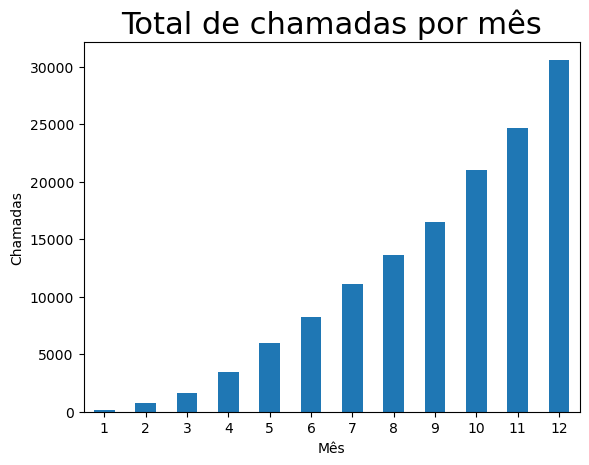

In [58]:
df_user_consum.groupby('month')['outgoing_calls'].sum().plot(kind='bar')
plt.title('Total de chamadas por mês', fontsize = 22)
plt.ylabel('Chamadas')
plt.xlabel('Mês')
plt.xticks(rotation = 0);

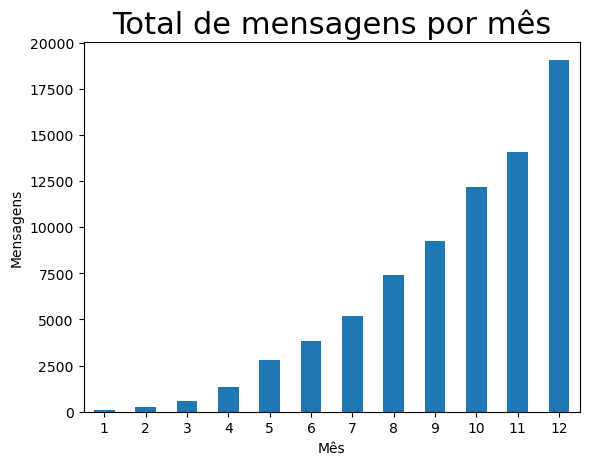

In [59]:
df_user_consum.groupby('month')['messages_sent'].sum().plot(kind='bar')
plt.title('Total de mensagens por mês', fontsize = 22)
plt.ylabel('Mensagens')
plt.xlabel('Mês')
plt.xticks(rotation = 0);

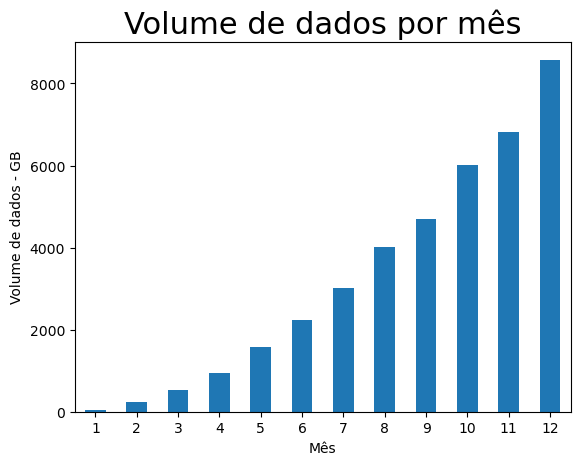

In [60]:
df_user_consum.groupby('month')['gb_used'].sum().plot(kind='bar')
plt.title('Volume de dados por mês', fontsize = 22)
plt.ylabel('Volume de dados - GB')
plt.xlabel('Mês')
plt.xticks(rotation = 0);

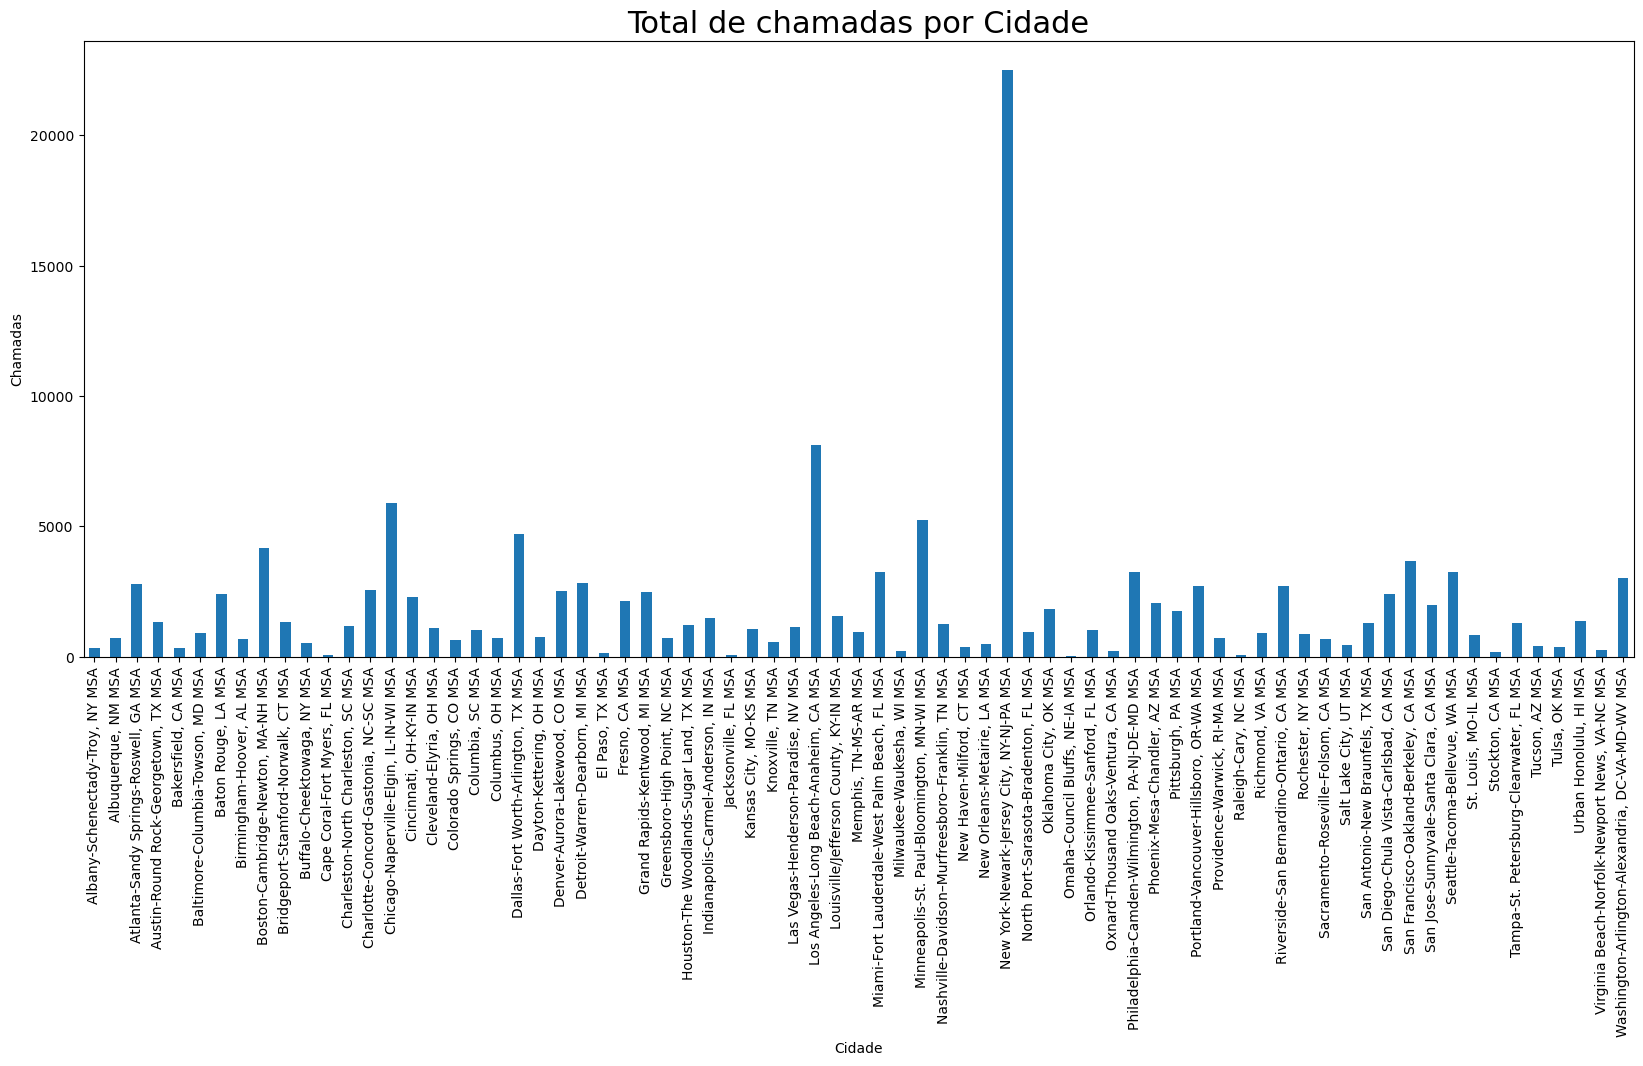

In [61]:
df_user_consum.groupby('city')['outgoing_calls'].sum().plot(kind='bar', figsize=(20, 8))
plt.title('Total de chamadas por Cidade', fontsize = 22)
plt.ylabel('Chamadas')
plt.xlabel('Cidade')
plt.xticks(rotation = 90);

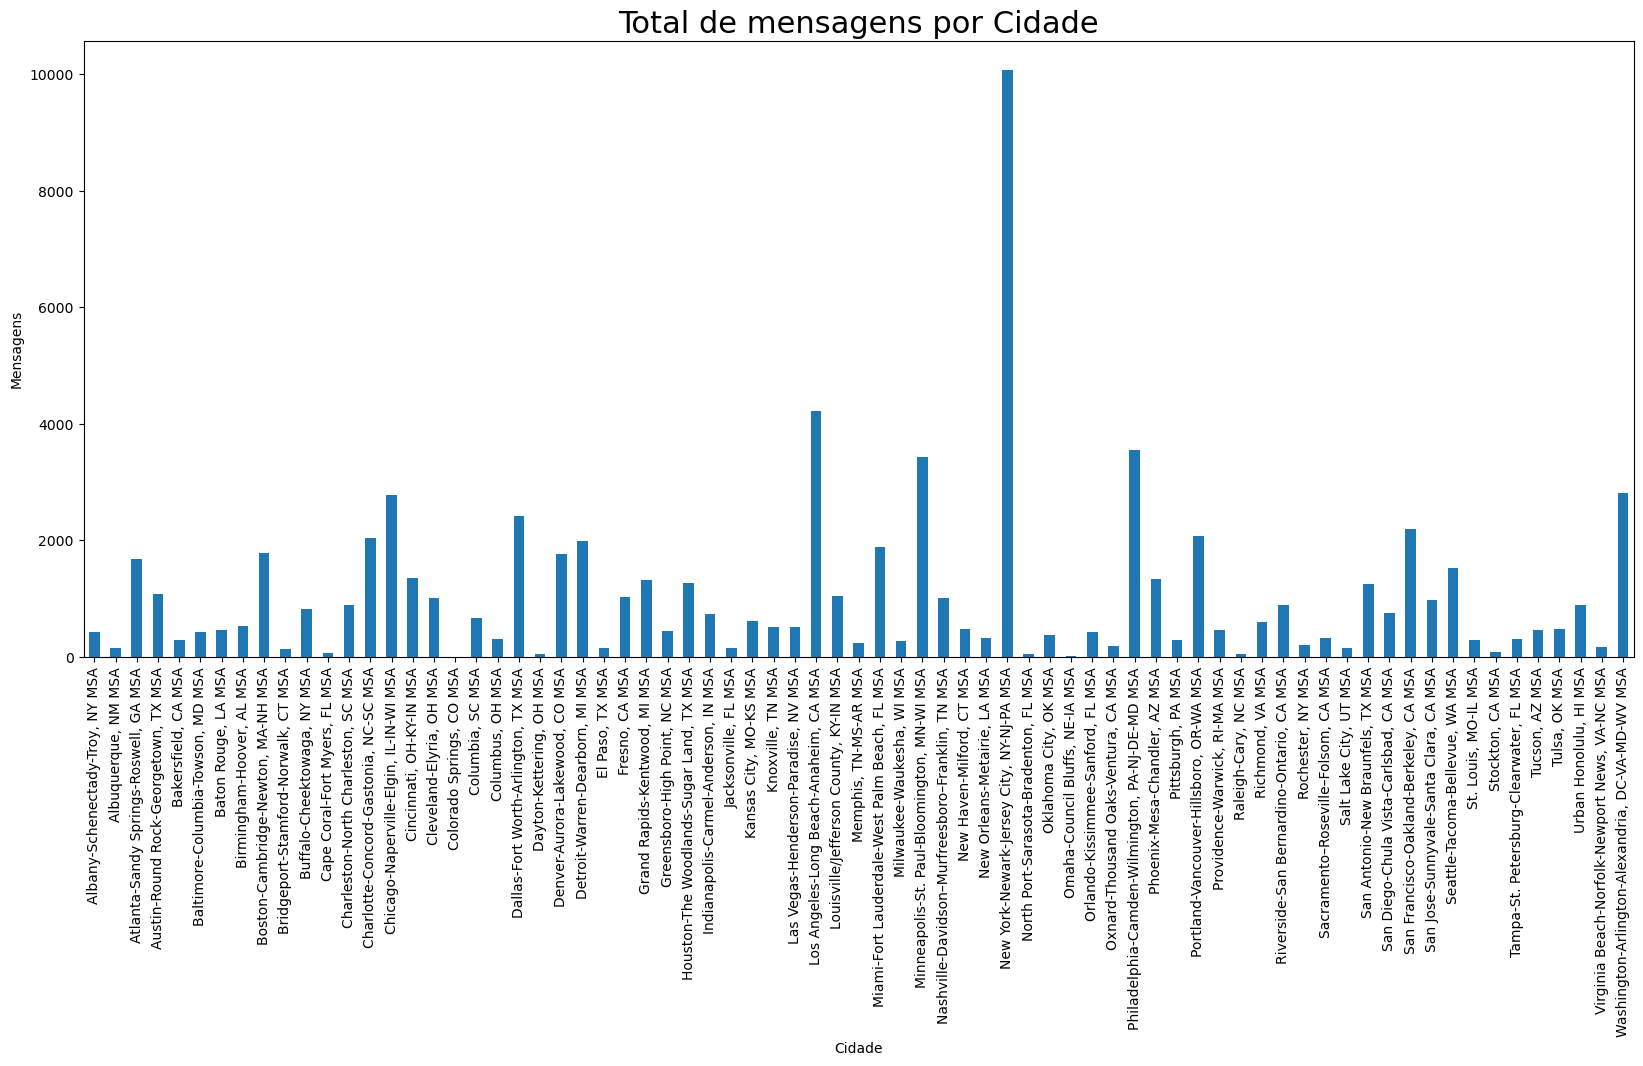

In [62]:
df_user_consum.groupby('city')['messages_sent'].sum().plot(kind='bar', figsize=(20, 8))
plt.title('Total de mensagens por Cidade', fontsize = 22)
plt.ylabel('Mensagens')
plt.xlabel('Cidade')
plt.xticks(rotation = 90);

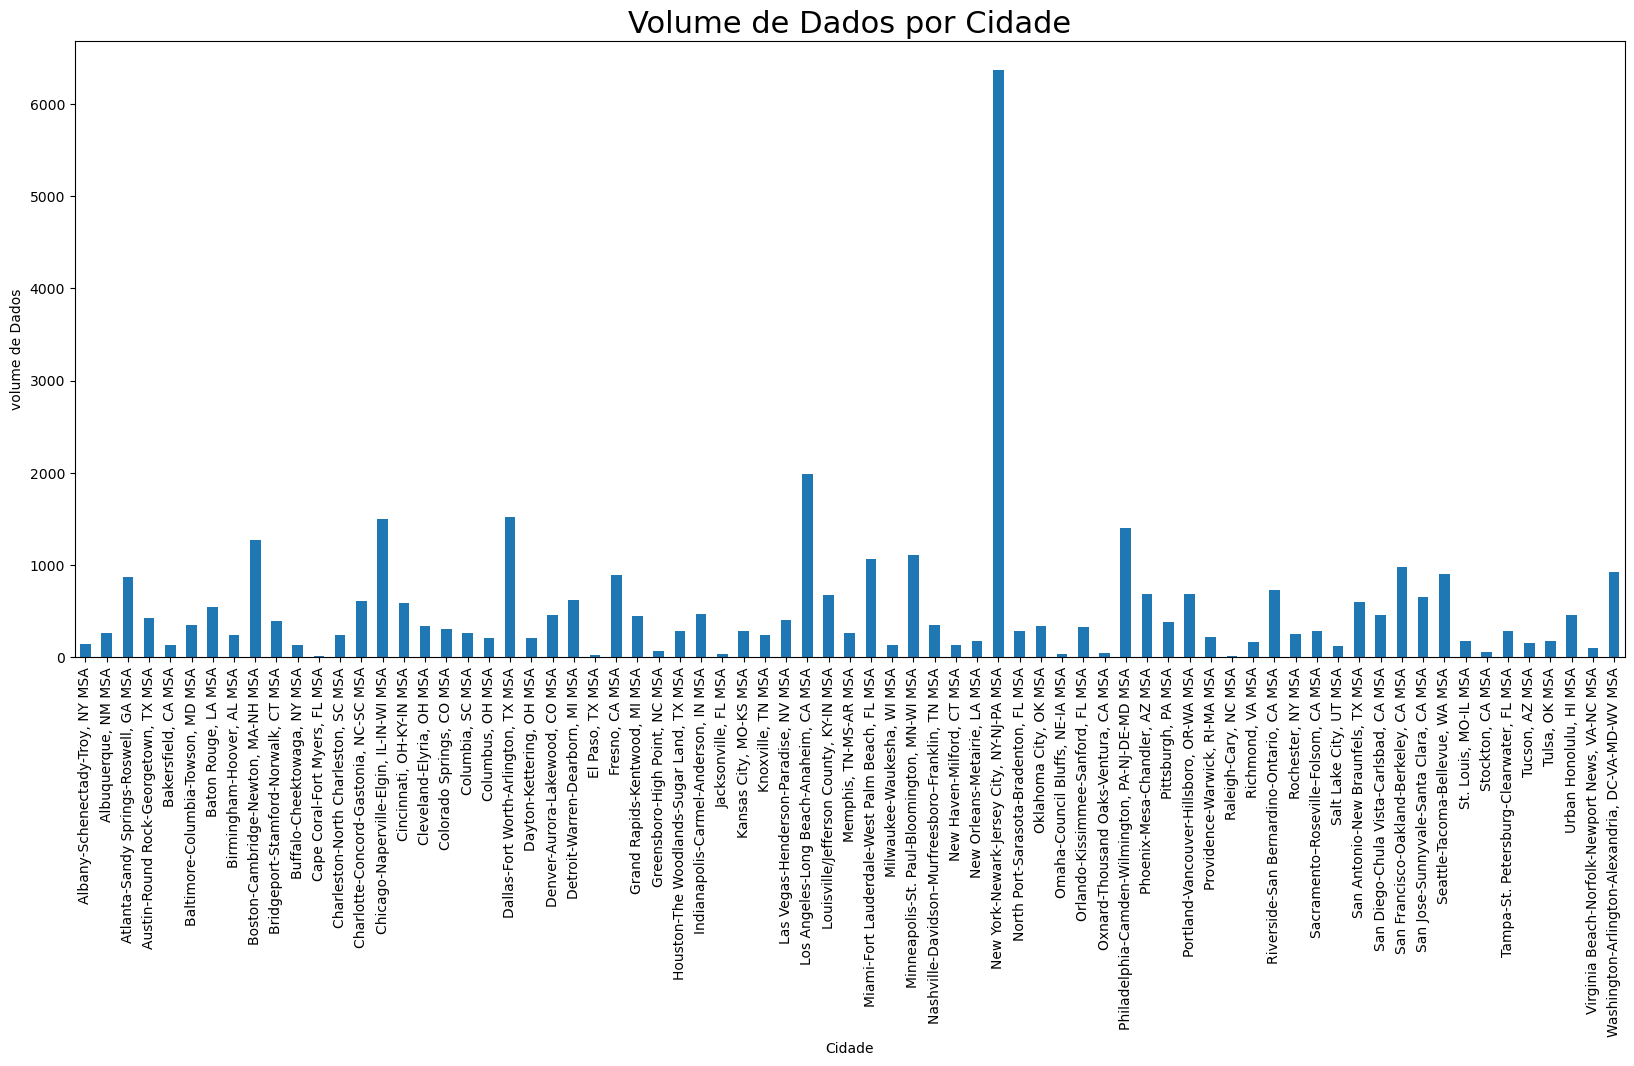

In [63]:
df_user_consum.groupby('city')['gb_used'].sum().plot(kind='bar', figsize=(20, 8))
plt.title('Volume de Dados por Cidade', fontsize = 22)
plt.ylabel('volume de Dados')
plt.xlabel('Cidade')
plt.xticks(rotation = 90);

### Receita

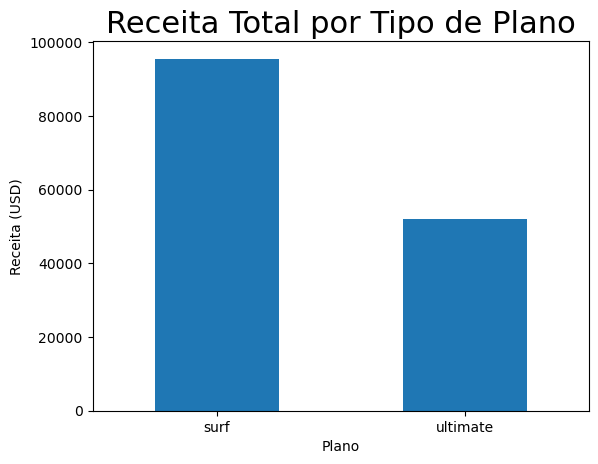

In [64]:
df_user_consum.groupby('plan')['to_pay'].sum().plot(kind='bar')
plt.title('Receita Total por Tipo de Plano', fontsize = 22)
plt.ylabel('Receita (USD)')
plt.xlabel('Plano')
plt.xticks(rotation = 0);

In [65]:
df_users.groupby('plan')['age'].count()

plan
surf        339
ultimate    161
Name: age, dtype: int64

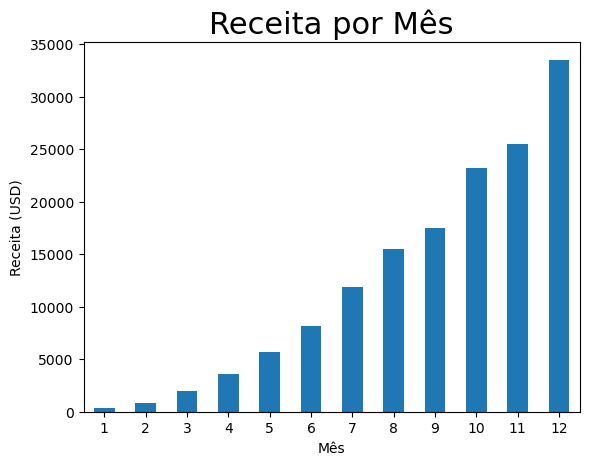

In [66]:
df_user_consum.groupby('month')['to_pay'].sum().plot(kind='bar')
plt.title('Receita por Mês', fontsize = 22)
plt.ylabel('Receita (USD)')
plt.xlabel('Mês')
plt.xticks(rotation = 0);

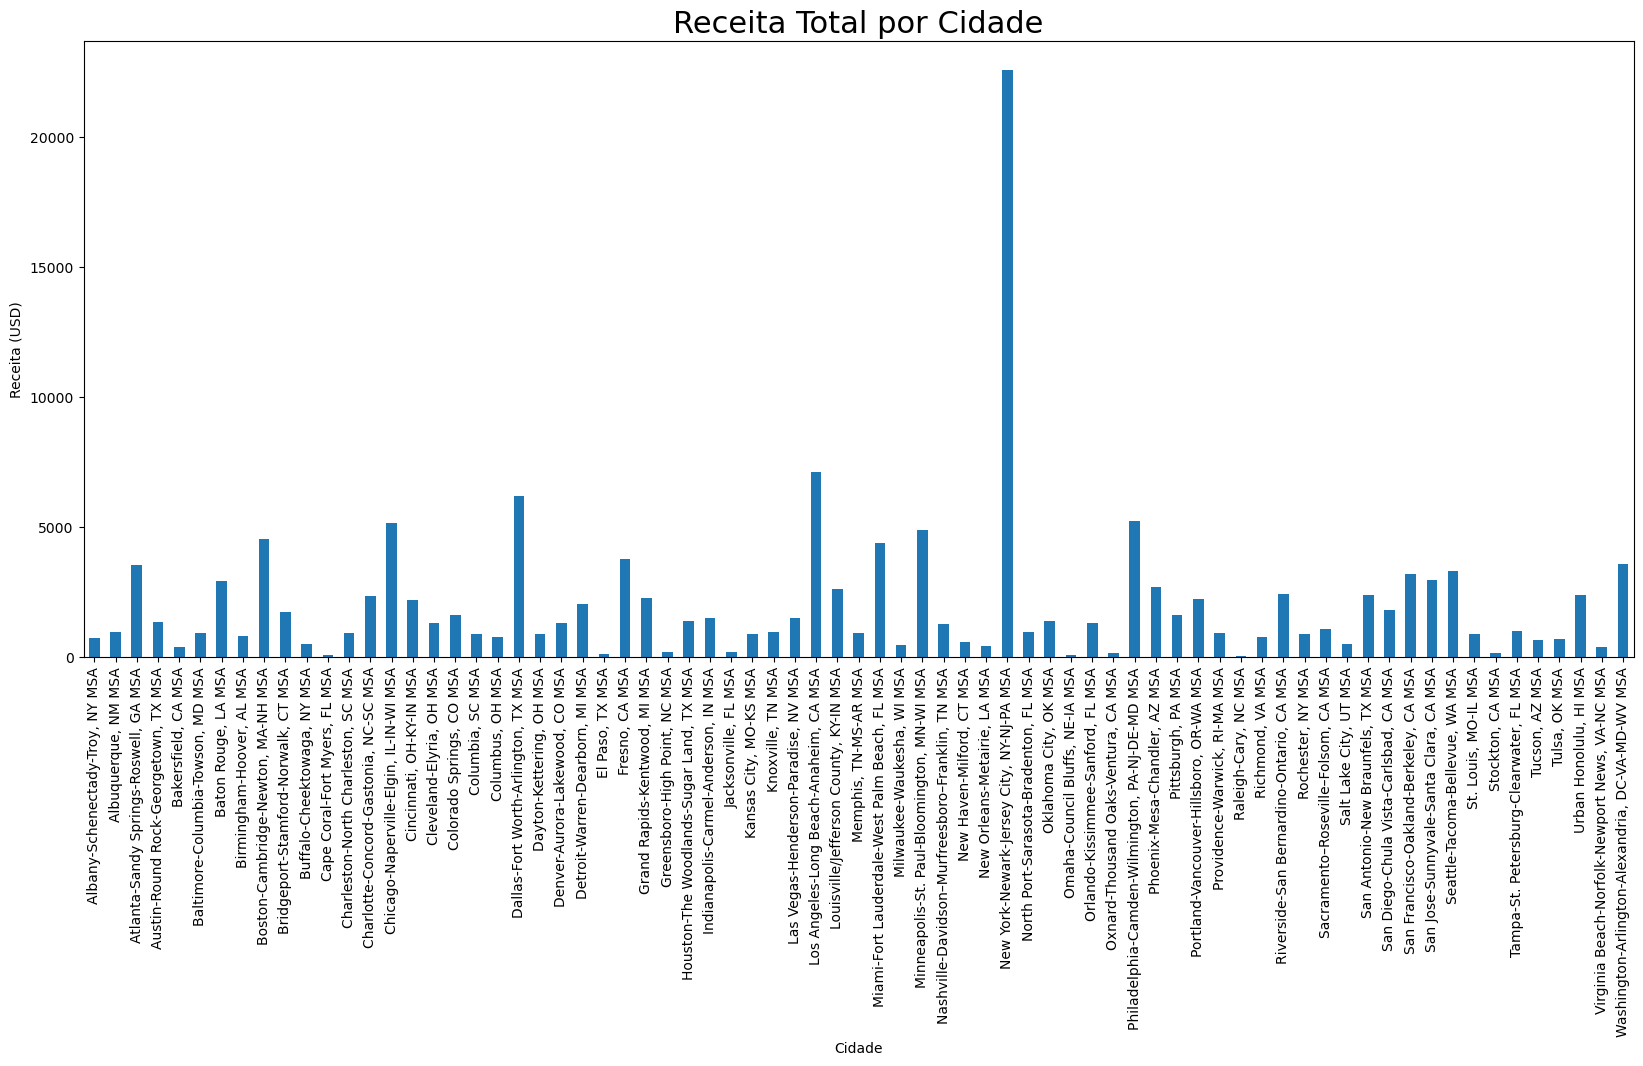

In [67]:
df_user_consum.groupby('city')['to_pay'].sum().plot(kind='bar', figsize=(20, 8))
plt.title('Receita Total por Cidade', fontsize = 22)
plt.ylabel('Receita (USD)')
plt.xlabel('Cidade')
plt.xticks(rotation = 90);

## Conclusão  do Tópico

Bem, há clara diferença da composição da receita, em relação as cidades, NY-NJ é a grande geradora de receita entre todas as outras, observando que é a cidade que possui a maior quantidade de clientes.

Quando observamos os meses com maior receita, vemos que os últimos meses do ano possuem a maior geração de receita.

E por último em relação aos planos, o plano Surf gera uma receita superior ao plano Ultimate, devido a quantidade de clientes, enquanto o plano Surf conta com 339 clientes, o plano Ultimate conta com apenas 161 clientes.

# Teste de Hipóteses

## Hipótese 1

A Receita Média dos usuários dos planos Ultimate e Surf são diferentes?

* H0: A Receita Média dos planos Surf e Ultimate são iguais.
* H1: A Receita Média dos planos Surf e Ultimate são diferentes.

In [68]:
surf = df_user_consum[df_user_consum['plan'] == 'surf']['to_pay']
ulti = df_user_consum[df_user_consum['plan'] == 'ultimate']['to_pay']
alpha = .05


surf_a = DescrStatsW(surf)
ulti_b = DescrStatsW(ulti)
test = CompareMeans(surf_a, ulti_b)

z, p_value, gl = test.ttest_ind(usevar='pooled')
print('p_value:', p_value)

if p_value <= alpha:
    print('A Hipótese Nula foi rejeitada')
else:
    print('A Hipótese Nula não foi rejeitada')

p_value: 2.8626745106987475e-08
A Hipótese Nula foi rejeitada


## Hipótese 2

A Receita Média dos usuários da área de NY-NJ é diferente dos usuários de outras regiões?

* H0: A Receita Média dos clientes das cidades NY-NJ é igual à Receita Média das outras regiões.
* H1: A Receita Média dos clientes das cidades NY-NJ é diferente da Receita Média das outras regiões.

In [69]:
ny_nj = df_user_consum[df_user_consum['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['to_pay']
others = df_user_consum[df_user_consum['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['to_pay']
alpha = .05


ny_nj_2 = DescrStatsW(ny_nj)
others_2 = DescrStatsW(others)
test = CompareMeans(ny_nj_2, others_2)

z, p_value, gl = test.ttest_ind(usevar='unequal', alternative='two-sided', value=0)
print('p_value:', p_value)

if p_value <= alpha:
    print('A Hipótese Nula foi rejeitada')
else:
    print('A Hipótese Nula não foi rejeitada')

p_value: 0.033525615885300314
A Hipótese Nula foi rejeitada


## Hipótese 3

A Receita Média dos usuários do plano Surf é menor do que a Receita Média do plano Ultimate, já que este é $50,00 mais caro que aquele.

* H0: A Receita Média usuários do plano Surf é menor do que a Receita Média do plano Ultimate.
* H1: A Receita Média usuários do plano Surf é maior do que a Receita Média do plano Ultimate.

In [70]:
n_surf = df_user_consum[df_user_consum['plan'] == 'surf']['to_pay']
n_ulti = df_user_consum[df_user_consum['plan'] == 'ultimate']['to_pay']
alpha = .05


n_surf2 = DescrStatsW(n_surf)
n_ulti2 = DescrStatsW(n_ulti)
test = CompareMeans(n_surf2, n_ulti2)

z, p_value, gl = test.ttest_ind(usevar='unequal', alternative='smaller')
print('p_value:', p_value)

if p_value <= alpha:
    print('A Hipótese Nula foi rejeitada')
else:
    print('A Hipótese Nula não foi rejeitada')

p_value: 1.585195274056902e-15
A Hipótese Nula foi rejeitada


## Hipótese 4

A Receita Média dos usuários que excederam o plano Surf é menor do que a Receita Média do plano Ultimate, já que este é $50,00 mais caro que aquele.

* H0: A Receita Média usuários do plano Ultimate é maior que a Receita Média dos usuários que excederam o plano Surf.
* H1: A Receita Média usuários do plano Ultimate é menor que a Receita Média dos usuários que excederam o plano Surf.

In [71]:
s_surf = df_user_consum[(df_user_consum['plan'] == 'surf') & (df_user_consum['to_pay'] > 20)]['to_pay']
s_ulti = df_user_consum[df_user_consum['plan'] == 'ultimate']['to_pay']
alpha = .05


s_surf2 = DescrStatsW(n_surf)
s_ulti2 = DescrStatsW(n_ulti)
test = CompareMeans(s_ulti2, s_surf2)

z, p_value, gl = test.ttest_ind(usevar='unequal', alternative='larger')
print('p_value:', p_value)

if p_value <= alpha:
    print('A Hipótese Nula foi rejeitada')
else:
    print('A Hipótese Nula não foi rejeitada')

p_value: 1.585195274056902e-15
A Hipótese Nula foi rejeitada


# Conclusão final


Inicialmente foi feita uma exploração dos dados, onde foi encontrado alguns pequenos erros e surgiu a idéia de criar um Data Frame único com dados tratados para facilitar e tornar a análise mais precisa. 

Bem, observa-se no decorrer da análise a predominância do uso do serviço nos últimos meses do ano, os gráficos mostram uma evolução do uso dos serviços, os motivos podem ser vários, mas não conseguimos precisar o motivo por falta de dados que possam corroborar as teses a serem elaboradas. 

Observa-se ainda que o plano Surf supera o plano Ultimate em quantidade de cliente, assim superando também em receita. Os clientes do plano Surf possuem uma media de limites excedidos muito superiores que o plano Ultimate, chegando a alguns clientes a pagar $590,37 no plano mensal, enquanto no plano ultimate o máximo registrado foi de $182,00. 

O comportamento de uso dos clientes parece não condizer com os planos contratados, superando muito os limites que o plano possui. Mas mesmo com essa discrepância da média dos valores pagos pelos usuários do plano Surf, em relação ao valor do próprio plano, a média de Receita do plano Ultimate é superior em $11,60. Ao todo são 339 clientes do plano Surf no total contra 131 do plano Ultimate.

Os clientes que pagam o excedente do plano Surf possuem uma receita média de $76,06, o que supera a receita média dos clientes do plano Ultimate que é de $72,31, como foi testado estatisticamente e a hipótese de que o plano ultimate teria a receita média maior foi rejeitada. 
    
Isso demonstra que o plano Surf não se adequa estatisticamente às necessidades dos clientes que o assinam, ou vice-versa. Ou seja, não cumpre o que é proposto. Já que a média por usuário do plano Surf é de $60,70/mês, enquanto a do plano Ultimate é de $72,31/mês.
    
A concentração de clientes em uma área mais ativa eletrônicamente como NY também favorece a essa atividade que excede o plano.

Ante o exposto, é aconselhável um programa de *"upgrade"* de plano para clientes que excedem o pacote oferecido pelo Plano Surf, de forma a aumentar a receita média do Plano Ultimate, estabilizando a receira, pois o Plano Surf mesmo com seu excedente e gerando mais receita, está sujeito a variações de acordo com o consumo dos usuários, sendo assim sujeito a mais volatilidade que o plano Ultimate. Essa discrepância de receita entre um e outro pode ser encarado como uma atipicidade pois decorreu de excedentes muito fora da média. 

